In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_extraction

Generisemo neki skup podataka koji ce se koristiti da se ilustruju koncepti vektorizacije recenica.

In [3]:
x = ['It is quite strange to have show in spring.',
     'Spring is strange to.']

## Vreca reci (eng. Bag of Words)
Osnovna ideja sa modelom *vrece reci* je da se u tekstu pronadju *sve* reci koje ostanu nakon koraka pretprocesiranja i da se na osnovu njih izgradi *vokabular* $V$ koji sadrzi $|V|$ reci.

Korak *pretprocesiranja* je korak u kojem se eliminisu interpunkcijski znaci, velika slova se pretvaraju u mala i slicno.

Reci se potom redjaju redom i dodeljuje im se redni broj. Recenica se predstavlja kao vektor dimenzije $|V|$ tako sto je $i$-ta koordinata 1 ukoliko je $i$-ta rec vokabulara prisutna u recenici, a 0 inace.

Bibiloteka `scikit-learn` sadrzi klasu `CountVectorizer` koja nudi funkcionalnost vektorizacije teksta u model vrece reci.

In [4]:
vectorized = feature_extraction.text.CountVectorizer()

In [5]:
vectorized.fit(x)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [6]:
vectorized.vocabulary_

{'it': 3,
 'is': 2,
 'quite': 4,
 'strange': 7,
 'to': 8,
 'have': 0,
 'show': 5,
 'in': 1,
 'spring': 6}

In [7]:
x_bag_of_words = vectorized.transform(x)

In [8]:
x_bag_of_words.shape

(2, 9)

Dimenzija promenljive `x_bag_of_words` je (2, 9) i to oznacava da:
- postoje 2 recenice,
- recenica je opisana sa 9 vrednosti (odnosno $|V| = 9$).

In [9]:
x_bag_of_words[0]

<1x9 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

Primetimo da ukoliko je vokabular *veliki* (ovo je tesko numericki egzaktno kvantifikovati), vektorizovane reprezentacije recenice ce imati veliki broj nula. Ovo je ocekivano jer u jednoj recenici verovatno ne figurise vecina reci koje jezik poseduje.

Usled toga, ukoliko bi se vektorizovane vrednosti cuvale kao `numpy ndarray`, za svaku nulu (kojih ima dosta) bi bila potrosena memorija. Ovakvo cuvanje podataka nazivamo gusto (eng. dense).

Resenje je cuvati samo one vrednosti koja su u manjini, a nule zapamtiti implicitino. Odnosno, cuvati samo vrednosti koje nisu nula. Ovakva ideja reprezentacije podataka naziva se *retka* reprezentacija (eng. sparse), i `CountVectorizer` podrazumevano vraca retku matricu kada se primeni vektorizacija.

In [10]:
vectorized.get_feature_names()

['have', 'in', 'is', 'it', 'quite', 'show', 'spring', 'strange', 'to']

Ukoliko ipak zelimo da dobijemo gustu reprezentaciju vektorizovane recenice, mozemo to uciniti pozivom metoda `toarray`.

In [11]:
x_bag_of_words.toarray()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 1, 1]])

## TF-IDF (Term Frequency - Inverse Document Frequency)

### Uopstavanje metoda vrece reci
Ukoliko razmislimo, vektorizovani oblik vrece reci i nije preterano informativan,
odnosno skup vrednosti koje koordinate vektora mogu uzimati je vrlo skroman, odnosno to je skup $\{0, 1\}$. Postavlja se pitanje da li mozemo da napravimo
neku meru koja bi recima (terminima) davala neku vrstu **ocene vaznosti** umesto
da se za rec odgovara da li postoji ili ne u recenici.

### O metrici Tf-idf
Tf-idf predstavlja meru koja se moze koristiti da se
kvantifikuje vaznost nekog termina, odnosno da se terminu dodeli **tezina**.
Tf-idf mera se dosta koristi u pretrazivanju informacija
(eng. information retrieval) i istrazivanju teksta (eng. text mining).

Vaznost termina (reci) raste sa brojem njegovog pojavljivanja u dokumentu, ali se
otezava njegovim ukupnim brojem pojavljivanja u celokupnom skupu dokumenata
(koji ima **vise** dokumenata).

Pretrazivaci dokumenata dosta cesto koriste ovu meru i njene varijacije
kako bi rangirali dokumente za upit koji je prosledio korisnik.

### Izracunavanje mere Tf-idf
Tezina *tf-idf* se sastoji iz dva clana:
- $TF(t, d)$ - Broj pojavljivanja reci $t$ u dokumentu $d$
- $IDF(t, d, D)$ - Logaritam kolicnike ukupnog broja dokumenata $d$ sa brojem dokumenata (iz skupa $D$ u kojima se pojavljuje termin $t$

U nasem primeru recenica koje imamo (vektor `x` sa pocetka), vazi:
- $D = \{d_1, d_2\}$
- $d_1 = $ "It is quite strange to have show in spring."
- $d_2 = $ "Spring is strange to."


#### Primer
Razmotrimo dokument $d$ koji sadrzi 100 reci u kojima rec se rec *macka* pojavljuje 3 puta.

TF("macka", $d$) = $\frac{3}{100}$ = 0.03

Pretpostavimo da imamo *10 miliona* dokumenata i rec "macka" se pojavljuje u 1000 od ovih. Tada:

IDF("macka", $D$) = $\log{(\frac{10 000 000}{1 000})} = 4$

Tako da mera *tf-idf* predstavlja proizvod nadjenih vrednosti, odnosno $0.03 \cdot 4 = 0.12$.

In [12]:
tf_idf_vectorizer = feature_extraction.text.TfidfVectorizer()

In [13]:
tf_idf_vectorizer.fit(x)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [14]:
tf_idf_vectorizer.get_feature_names()

['have', 'in', 'is', 'it', 'quite', 'show', 'spring', 'strange', 'to']

In [15]:
x_tfidf = tf_idf_vectorizer.transform(x)

In [16]:
x_tfidf.shape

(2, 9)

In [17]:
x_tfidf.toarray()

array([[0.37729199, 0.37729199, 0.26844636, 0.37729199, 0.37729199,
        0.37729199, 0.26844636, 0.26844636, 0.26844636],
       [0.        , 0.        , 0.5       , 0.        , 0.        ,
        0.        , 0.5       , 0.5       , 0.5       ]])

## SMS spam klasifikacija
U direktorijumu `smsspam` nalazi se datoteka `SMSSpamCollection` u kojoj
se nalazi skup podataka koji sadrzi sms poruke koje su oznacene kao spam i ne spam.

Struktura je sledeca:
```txt
LABELA\tSADRZAJ\n
```
Odnosno prvo ide labela:
- `spam` - ukoliko je poruka spam
- `ham` - ukoliko poruka nije spam

Potom sledi karakter `\t`, potom sadrzaj sms poruke sve do karaktera `\n`.


In [18]:
with open(os.path.join('smsspam', 'SMSSpamCollection')) as f:
    lines = [line.strip().split('\t') for line in f.readlines()]

In [19]:
text = [line[1] for line in lines]
y = [int(line[0] == 'spam') for line in lines]

In [20]:
text[2000:2010]

["LMAO where's your fish memory when I need it?",
 "But i'll b going 2 sch on mon. My sis need 2 take smth.",
 'Idea will soon get converted to live:)',
 'TheMob>Yo yo yo-Here comes a new selection of hot downloads for our members to get for FREE! Just click & open the next link sent to ur fone...',
 'S....s...india going to draw the series after many years in south african soil..',
 'Goodmorning, today i am late for  &lt;DECIMAL&gt; min.',
 "Can't take any major roles in community outreach. You rock mel",
 'Shopping lor. Them raining mah hard 2 leave orchard.',
 'Hi here. have birth at on the  to  at 8lb 7oz. Mother and baby doing brilliantly.',
 'See the forwarding message for proof']

In [21]:
n_spam = y.count(1)
n_nospam = y.count(0)
print('Broj spam poruka: {}'.format(n_spam))
print('Broj poruka koje nisu spam: {}'.format(n_nospam))
print('Ukupan broj poruka: {}'.format(len(y)))
print('Udeo spam poruka od ukupnih poruka: {}'.format(n_spam/len(y)))

Broj spam poruka: 747
Broj poruka koje nisu spam: 4827
Ukupan broj poruka: 5574
Udeo spam poruka od ukupnih poruka: 0.1340150699677072


In [22]:
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(text, y, test_size=0.33, random_state=7, stratify=y)

In [23]:
# NOTETOSELF: min_df
spam_vectorizer = feature_extraction.text.CountVectorizer()

In [24]:
spam_vectorizer.fit(text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [25]:
x_train_vectorized = spam_vectorizer.transform(X_train)
x_test_vectorized = spam_vectorizer.transform(X_test)

In [26]:
print('Broj reci u trening skupu {}'.format(x_train_vectorized.shape[0]))
print(x_test_vectorized.shape)

Broj reci u trening skupu 3734
(1840, 8716)


In [27]:
spam_vectorizer.get_feature_names()[2000:2020]

['cheered',
 'cheers',
 'cheery',
 'cheese',
 'cheesy',
 'cheetos',
 'chef',
 'chennai',
 'cheque',
 'cherish',
 'cherthala',
 'chess',
 'chest',
 'chex',
 'cheyyamo',
 'chez',
 'chg',
 'chgs',
 'chic',
 'chick']

In [28]:
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_model.fit(x_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
logistic_regression_train_score = logistic_regression_model.score(x_train_vectorized, y_train)
logistic_regression_test_score = logistic_regression_model.score(x_test_vectorized, y_test)

In [30]:
print(logistic_regression_train_score)
print(logistic_regression_test_score)

0.997589716122121
0.9815217391304348


In [31]:
svm_model = svm.LinearSVC()
svm_model.fit(x_train_vectorized, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [32]:
svm_train_score = svm_model.score(x_train_vectorized, y_train)
print(svm_train_score)

1.0


In [33]:
svm_test_score = svm_model.score(x_test_vectorized, y_test)
print(svm_test_score)

0.9858695652173913


In [34]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=4)
knn_model.fit(x_train_vectorized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [35]:
knn_train_score = knn_model.score(x_train_vectorized, y_train)
print(knn_train_score)

0.9242099625066952


In [36]:
knn_test_score = knn_model.score(x_test_vectorized, y_test)
print(knn_test_score)

0.9092391304347827


In [37]:
def visualize_coefficients(title, classifier, feature_names, n_top_features=25):
    coefs = classifier.coef_.ravel()
    
    positive_coefficients_indices = np.argsort(coefs)[-n_top_features:]
    negative_coefficients_indices = np.argsort(coefs)[:n_top_features]
    
    interesting_coefficients_indices =\
        np.hstack([negative_coefficients_indices,
                   positive_coefficients_indices])
    
    plt.figure(figsize=(15,5))
    plt.title(title)
    colors = ['orange' if c < 0 else 'cadetblue' for c in coefs[interesting_coefficients_indices]]
    plt.bar(np.arange(2 * n_top_features),
            coefs[interesting_coefficients_indices], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(2*n_top_features), feature_names[interesting_coefficients_indices], rotation=60, ha='right')

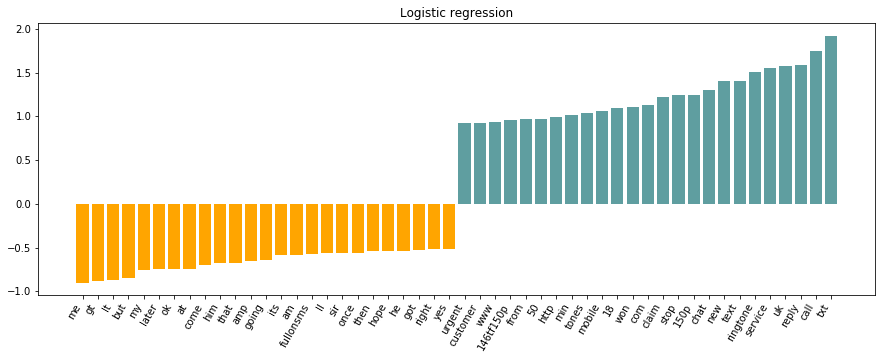

In [38]:
visualize_coefficients('Logistic regression',
                      logistic_regression_model,
                      spam_vectorizer.get_feature_names())

In [40]:
# Kako radi argsort?
tmp = np.array([1, 5, 2, 3])
sorted_tmp = np.argsort(tmp)
print(tmp[sorted_tmp])
print(sorted_tmp)

[1 2 3 5]
[0 2 3 1]
